# [**AdaBoost discret vs. réel**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensembles/plot_adaboost_hastie_10_2.ipynb)<br/>([*Discrete versus Real AdaBoost*](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html))

Ce cahier est basé sur la figure 10.2 de Hastie et al 2009 [1] et illustre la différence de performances entre l'algorithme de boost discret SAMME [2] et l'algorithme de boost réel SAMME.R. Les deux algorithmes sont évalués sur une tâche de classification binaire où la cible Y est une fonction non linéaire de 10 caractéristiques d'entrée.

Le SAMME discret AdaBoost s'adapte en fonction des erreurs dans les étiquettes de classe prédites tandis que le vrai SAMME.R utilise les probabilités de classe prédites.

[1] T. Hastie, R. Tibshirani et J. Friedman, [“**Elements of Statistical Learning Ed. 2**](https://hastie.su.domains/Papers/ESLII.pdf)[”](https://drive.google.com/file/d/1wbK7Ii8bQliX7D3rKyGoR0-gxqJZ11iN/view?usp=share_link), Springer, 2009.

[2] J Zhu, H. Zou, S. Rosset, T. Hastie, ["**Multi-class AdaBoost**](https://www.intlpress.com/site/pub/files/_fulltext/journals/sii/2009/0002/0003/SII-2009-0002-0003-a008.pdf)["](https://drive.google.com/file/d/1xqvN5UIc9VebtSAwMJrUI-3LPRKSaQ4g/view?usp=share_link), Statistics and Its Interface, 2009.

## Préparation des données et des modèles de base

Nous commençons par générer le jeu de données de classification binaire utilisé dans Hastie et al. 2009, exemple 10.2.

In [1]:
# Authors: Peter Prettenhofer <peter.prettenhofer@gmail.com>,
#          Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12_000, random_state=1)

Maintenant, nous définissons les hyperparamètres pour nos classifieurs AdaBoost. Soyez conscient qu'un taux d'apprentissage de 1,0 peut ne pas être optimal pour SAMME et SAMME.R

In [2]:
n_estimators = 400
learning_rate = 1.0

Nous avons divisé les données en un ensemble d'entraînement et un ensemble de test. Ensuite, nous entraînons nos classificateurs de base, un `DecisionTreeClassifier` avec `depth=9` et un `DecisionTreeClassifier` « souche » avec `depth=1` et calculons l'erreur de test.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2_000, shuffle=False
)

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

# Adaboost avec SAMME discret et SAMME.R réel

Nous définissons maintenant les classifieurs AdaBoost discrets et réels et les adaptons à l'ensemble d'apprentissage.

In [4]:
from sklearn.ensemble import AdaBoostClassifier

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME",
)
ada_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

In [5]:
ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)
ada_real.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

Maintenant, calculons l'erreur de test des classifieurs AdaBoost discrets et réels pour chaque nouvelle souche dans `n_estimators` ajoutés à l'ensemble.

In [6]:
import numpy as np
from sklearn.metrics import zero_one_loss

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

# Graphique les résultats

Enfin, nous traçons les erreurs d'entraînement et de test de nos lignes de base et des classifieurs AdaBoost discrets et réels

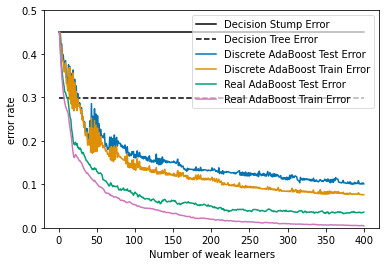

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

colors = sns.color_palette("colorblind")

ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err,
    label="Discrete AdaBoost Test Error",
    color=colors[0],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err_train,
    label="Discrete AdaBoost Train Error",
    color=colors[1],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color=colors[2],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color=colors[4],
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("Number of weak learners")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

# Remarques finales

Nous observons que le taux d'erreur pour les ensembles d'entraînement et de test d'AdaBoost réel est inférieur à celui d'AdaBoost discret.